<a href="https://colab.research.google.com/github/w-dan/MATM/blob/main/MATM-code/data-analysis/clauses_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install nltk

# APT Reports with Clause Separation Dataset

This notebook performs the following steps:
1. Connect to the MongoDB database and retrieve the APT reports.
2. Separate the reports into individual clauses.
3. Analyze the length of phrases, words, and the frequency of words.
4. Plot the length of words and filter out clauses longer than 300 words.

## Sections:
- Functions
- Data Retrieval and Processing
- Analysis and Visualization


## Setup

In [26]:
# Functions

import pandas as pd
import nltk, re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from pymongo import MongoClient
import os
from typing import List, Dict, Any
import re
from dotenv import load_dotenv
import seaborn as sns

In [27]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def connect_to_mongodb(connection_string: str) -> MongoClient:
    """
    Connect to the MongoDB database using the provided connection string.

    Args:
    connection_string (str): The connection string for MongoDB.

    Returns:
    MongoClient: The MongoDB client.
    """
    return MongoClient(connection_string)


def get_data_from_mongodb(client: MongoClient, db_name: str, collection_name: str) -> pd.DataFrame:
    """
    Retrieve data from MongoDB and return it as a pandas DataFrame.

    Args:
    client (MongoClient): The MongoDB client.
    db_name (str): The database name.
    collection_name (str): The collection name.

    Returns:
    pd.DataFrame: The data retrieved from MongoDB.
    """
    db = client[db_name]
    collection = db[collection_name]
    data = list(collection.find())
    return pd.DataFrame(data)


def remove_non_ascii(text: str) -> str:
    """
    Remove non-ASCII characters from a given text.

    Args:
    text (str): Input text.

    Returns:
    str: Text with non-ASCII characters removed.
    """
    return re.sub(r'[^\x00-\x7F]+', '', text)

In [29]:
load_dotenv()
connection_string = os.getenv("CONNECTION_STRING")


client = connect_to_mongodb(connection_string)
data_df = get_data_from_mongodb(client, "APTs", "raw_reports")

In [30]:
data_df['corpus'] = data_df['corpus'].apply(remove_non_ascii)

In [31]:
data_df

,_id,hash,corpus
0,661f838fe61552357fb5114a,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,Decoding network data from a Gh0st RAT variant...
1,661f838fe61552357fb5114b,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,1 / 1 5www .prevailion.com /what-wicked-webs-...
2,661f838fe61552357fb5114c,d3d1f3a690d13bcf37b2616c6111dae6e66650189fa677...,1 / 7www .mandiant.com /resources/blog/lights...
3,661f8391e61552357fb5114d,d10ace962f97771a08fdb888d37e47318b38936894e5c3...,2015/11/24 Russian financial cybercrime: how i...
4,661f8391e61552357fb5114e,9f61d6a9f2e2b6f6f9f236ef26b7dab3fc33eef953a8a2...,"9/28/21, 4:23 PM FoggyW eb: T argeted NOBELIUM..."
...,...,...,...
4490,662127f03042a7b5ed7205b6,11790f7c980834182507704053a0c0717511b077e17f7c...,Secrets of the Comfoo MastersAuthor: Joe Stewa...
4491,662127f03042a7b5ed7205b7,6d3c151d582468fd2f33f8783f9926fe8160300d0cca13...,THREAT INTELLIGENCE REPORT \nCYBERATTACKS AGAI...
4492,662127f03042a7b5ed7205b8,8dde659048cdbac57c566f88ea89fdacf8cabcb2521b0b...,\n1 \n \nVisa Security Alert AUGUST ...
4493,662127f03042a7b5ed7205b9,ea10fd8c4838658ccc50af6dbaa08a84caf9cc3fe99421...,1 / 3Graphiron: New Russian Information Steali...


# Functions

In [32]:
def separate_into_clauses(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Separate the text in a DataFrame column into clauses.

    Args:
    df (pd.DataFrame): DataFrame containing the text data.
    text_column (str): Name of the column containing the text to be separated.

    Returns:
    pd.DataFrame: DataFrame with each clause as a separate row.
    """
    clauses = []
    for index, row in df.iterrows():
        text = row[text_column]
        hash = row["hash"]
        sentences = sent_tokenize(text)
        for sentence in sentences:
            clauses.append({'report_hash': hash, 'clause': sentence})

    df_clauses = pd.DataFrame(clauses)
    df_clauses['length'] = df_clauses['clause'].apply(calculate_word_length)

    return df_clauses


def preprocess_text(text: str) -> str:
    """
    Preprocess text by removing non-ASCII characters, stopwords, and converting to lowercase.

    Args:
    text (str): Input text.

    Returns:
    str: Preprocessed text.
    """
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


def calculate_word_length(clause: str) -> int:
    """
    Calculate the word length of a clause.

    Args:
    clause (str): A text clause.

    Returns:
    int: The number of words in the clause.
    """
    return len(clause.split())


def filter_long_clauses(df: pd.DataFrame, text_column: str, max_length: int, min_length: int) -> pd.DataFrame:
    """
    Filter out clauses longer than a specified number of words and shorter than a specified number of words.

    Args:
    df (pd.DataFrame): DataFrame containing the clauses.
    text_column (str): Name of the column containing the text clauses.
    max_length (int): Maximum number of words allowed in a clause.
    min_length (int): Minimum number of words allowed in a clause.

    Returns:
    pd.DataFrame: Filtered DataFrame with only clauses within the specified length range.
    """
    max_df = df[df['length'] <= max_length]
    final_df = max_df[max_df['length'] > min_length]
    return final_df


def plot_word_length_distribution(word_lengths: List[int]) -> None:
    """
    Plot the distribution of word lengths with more focus on lower values.

    Args:
    word_lengths (List[int]): A list of word lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(word_lengths, bins=30, range=(0, 30), alpha=0.75, color='blue', edgecolor='black')
    plt.title('Word Length Distribution')
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def plot_length_boxplot(data: pd.DataFrame) -> None:
    """
    Plots a boxplot for the 'length' column in the dataframe.

    Args:
    data (pd.DataFrame): The dataframe containing the 'length' column.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['length'])
    plt.title('Boxplot of Clause Lengths')
    plt.xlabel('Length (in words)')
    plt.show()

# Dataset creation

In [33]:
raw_clauses_df = separate_into_clauses(data_df, "corpus")
raw_clauses_df

,report_hash,clause,length
0,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,Decoding network data from a Gh0st RAT variant...,36
1,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,"From our research, we believe that the perpetr...",17
2,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,"In fact, the main goal was to mine cryptocurre...",9
3,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,During the\ninvestigation we found several too...,25
4,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,Even\nthough Bitdefender and TrendMicro have p...,35
...,...,...,...
859828,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,MITRE ATT&CK Framework Groups \n<https://att...,7
859829,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,APT Groups and Operations \n<https://apt.thre...,7
859830,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,Malpedia \n<https://malpedia.caad.fkie.fraunh...,4
859831,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,ThaiCERT Risk Intelligence archive and extensi...,10


In [34]:
clauses_df = raw_clauses_df.copy()
clauses_df['clause'] = raw_clauses_df['clause'].apply(preprocess_text)

clauses_df

,report_hash,clause,length
0,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,decoding network data gh0st rat variant nccgro...,36
1,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,"research, believe perpetrator hasnt shown adva...",17
2,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,"fact, main goal mine cryptocurrency.",9
3,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,investigation found several tools password dum...,25
4,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,even though bitdefender trendmicro published r...,35
...,...,...,...
859828,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,mitre att&ck framework groups <https://attack....,7
859829,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,apt groups operations <https://apt.threattrack...,7
859830,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,malpedia <https://malpedia.caad.fkie.fraunhofe...,4
859831,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,thaicert risk intelligence archive extensive s...,10


# Analysis and visualization

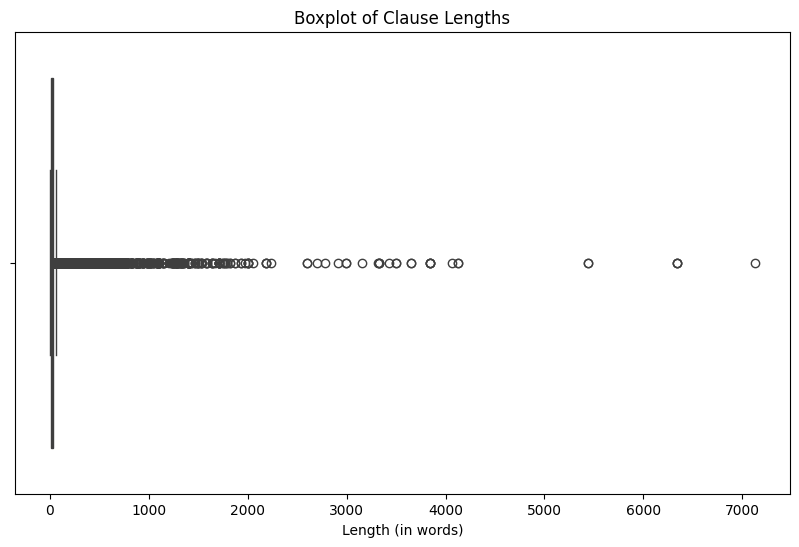

In [35]:
plot_length_boxplot(clauses_df)

A lot of atypical data are present in the clauses dataset, let's filter out the most troublesome ones in terms of length:

In [36]:
filtered_clauses_df = filter_long_clauses(clauses_df, "clause", 500, 60)
filtered_clauses_df

,report_hash,clause,length
32,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,!th 00000050: 69732070726f6772 616d2063616e6e6...,95
35,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,1 / 1 5www .prevailion.com /what-wicked-webs-w...,76
58,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,part ii: findings iia: naver -themed phishing ...,72
127,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,due ease operator create new subdomains hostin...,66
250,d3d1f3a690d13bcf37b2616c6111dae6e66650189fa677...,"accomplish this, lightshow drops legitimate ve...",63
...,...,...,...
859793,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,<https://www.fortinet.com/blog/threat -researc...,63
859797,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,observed tools used operations performed aug 2...,72
859798,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,<https://securelist.com/darkpulsar/88199/ > ap...,131
859799,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,(2017) <https://blacklakesecurity.com/who -was...,65


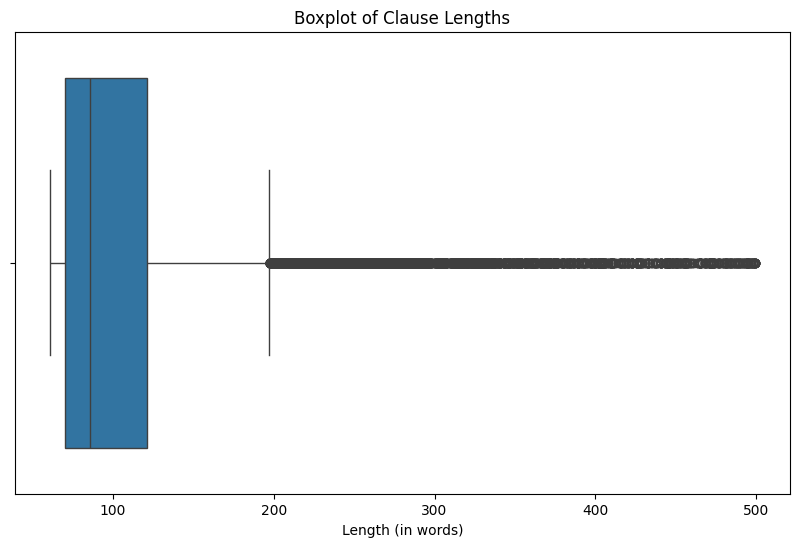

In [37]:
plot_length_boxplot(filtered_clauses_df)

In [38]:
filtered_clauses_df = filter_long_clauses(clauses_df, "clause", 200, 60)
filtered_clauses_df

,report_hash,clause,length
32,81eea0c65263dc9dcea5ab90f4abf688baec52d4fd83c0...,!th 00000050: 69732070726f6772 616d2063616e6e6...,95
35,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,1 / 1 5www .prevailion.com /what-wicked-webs-w...,76
58,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,part ii: findings iia: naver -themed phishing ...,72
127,e89c2c8e4c2b12b6d75cb11d9da439125e8ee9ad9bce84...,due ease operator create new subdomains hostin...,66
250,d3d1f3a690d13bcf37b2616c6111dae6e66650189fa677...,"accomplish this, lightshow drops legitimate ve...",63
...,...,...,...
859793,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,<https://www.fortinet.com/blog/threat -researc...,63
859797,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,observed tools used operations performed aug 2...,72
859798,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,<https://securelist.com/darkpulsar/88199/ > ap...,131
859799,677ad330b8837aeca70ed10d8ac8c7e444d761a5c39ad1...,(2017) <https://blacklakesecurity.com/who -was...,65


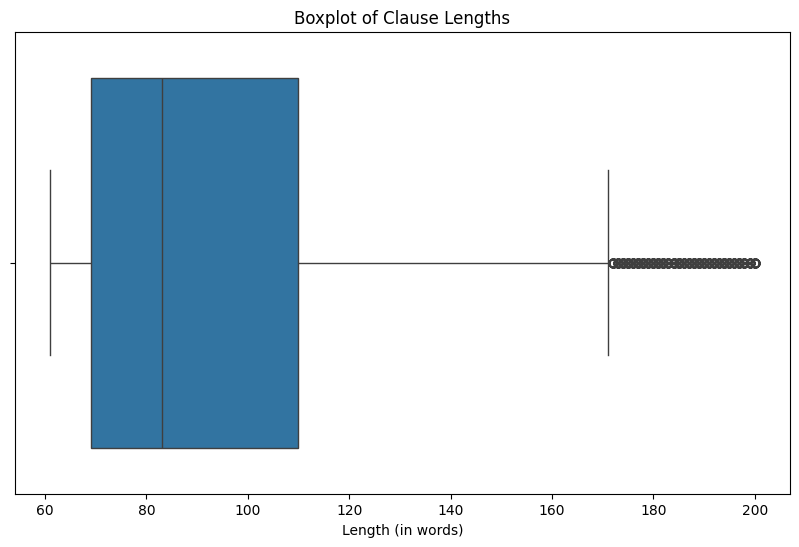

In [39]:
plot_length_boxplot(filtered_clauses_df)

A much more treatable dataset, we will save it as a csv in order to hand-tag it:

In [40]:
filtered_clauses_df.to_csv('filtered_clauses.csv', index=False, escapechar='\\')